# Causal Inference 1: Age Based

## Hypothesis Statement for Age-Based Uplift

- **Null Hypothesis (H₀):** Being in the “Older” age group **does not** significantly affect the likelihood of fraud compared to the “Younger” group.  
- **Alternative Hypothesis (H₁):** Being in the “Older” age group **does** significantly affect (increase or decrease) the likelihood of fraud compared to the “Younger” group.

In [2]:
!pip install causalml --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from causalml.inference.tree import UpliftTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind

Failed to import duecredit due to No module named 'duecredit'


In [17]:
# Load dataset
df = pd.read_csv('data/processed_train_set.csv')

# Drop unused variables
df.drop(columns=['Transaction_Amount', 'Transaction_Location'], inplace=True)

In [18]:
# Create Age_Group by binning Age into 'Younger' and 'Older'
df['Age_Group'] = pd.qcut(df['Age'], q=2, labels=['Younger', 'Older'])
df['Age_Group'] = df['Age_Group'].astype(str)  # Ensure Age_Group is of type string


In [19]:
# Define features and target
features = [col for col in df.columns if col not in ['Is_Fraud', 'Age_Group']]
X = df[features]
y = df['Is_Fraud']

# Convert boolean features to integers
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)


C:\Users\Palvi\AppData\Local\Temp\ipykernel_26760\220670434.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)


In [20]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, df['Age_Group'], test_size=0.2, random_state=42
)

In [21]:
# Initialize and train UpliftTreeClassifier
uplift_model = UpliftTreeClassifier(control_name='Younger', max_depth=4, min_samples_leaf=100)
uplift_model.fit(X_train.values, treatment_train.values, y_train.values)

# Predict uplift scores
cate_scores = uplift_model.predict(X_test.values)

# Extract the correct uplift column
cate_scores = cate_scores[:, 1]  # Selecting the column corresponding to the treatment group (Older)

# Store results in a DataFrame
results_df = X_test.copy()
results_df['Age_Group'] = treatment_test.values
results_df['Fraud'] = y_test.values
results_df['CATE'] = cate_scores  # Now a valid 1D array

# Display summary statistics of CATE
print("CATE Summary Statistics:")
print(results_df.groupby('Age_Group')['CATE'].describe())

CATE Summary Statistics:
             count      mean       std       min       25%       50%  \
Age_Group                                                              
Older      15504.0  0.070545  0.006719  0.050594  0.070383  0.070383   
Younger    16496.0  0.070525  0.006753  0.050594  0.070383  0.070383   

                75%       max  
Age_Group                      
Older      0.071554  0.082102  
Younger    0.071554  0.082102  


**Insights**

- Both Older and Younger have very similar mean CATE values (~0.0705), suggesting that the uplift (i.e., the additional likelihood of fraud attributed to being in the Older group) is almost the same as for Younger.
- The standard deviations are also similar (~0.0067), indicating comparable variability in estimated uplift for both groups.
- The quartiles (25%, 50%, 75%) and the min/max values reveal nearly overlapping ranges, reinforcing that there isn’t a large or consistent difference between Older and Younger in this model’s predictions.
- Taken together, these statistics suggest that being in the Older group does not show a marked increase or decrease in fraud risk relative to Younger based solely on these uplift estimates.

C:\Users\Palvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Palvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


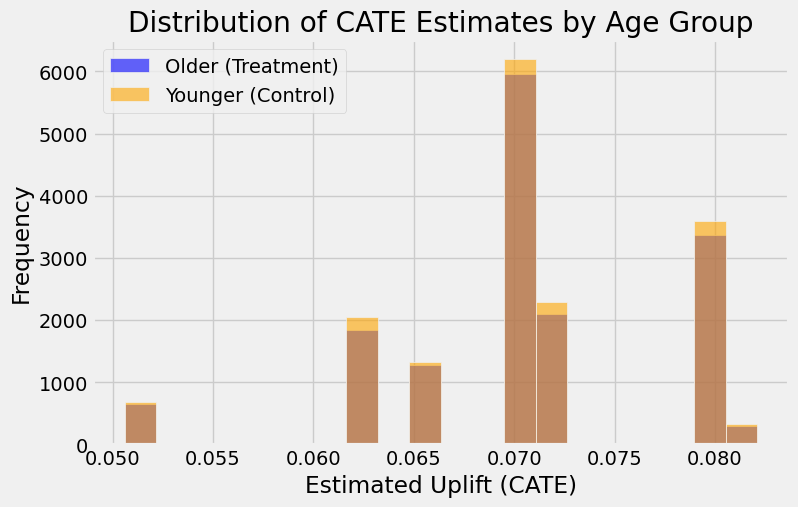

In [22]:
# Visualize the CATE distribution
plt.figure(figsize=(8,5))
sns.histplot(results_df[results_df['Age_Group'] == 'Older']['CATE'], bins=20, color='blue', label="Older (Treatment)", alpha=0.6)
sns.histplot(results_df[results_df['Age_Group'] == 'Younger']['CATE'], bins=20, color='orange', label="Younger (Control)", alpha=0.6)
plt.xlabel("Estimated Uplift (CATE)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of CATE Estimates by Age Group")
plt.show()

**Interpretation of the CATE Distributions**

- Both histograms peak around 0.070, suggesting that the average estimated uplift is nearly the same for Older and Younger.
- The shape and spread of the two distributions are similar, indicating minimal difference in fraud likelihood uplift between the two age groups.
- The slight overlap across the entire range (roughly 0.05 to 0.08) reinforces that being Older does not appear to confer a systematically higher or lower risk compared to Younger, at least based on this model.
- Overall, the visualization supports the notion that age group does not show a clear-cut causal impact on fraud in this dataset.

In [23]:
# Statistical test for CATE comparison
older_cate = results_df[results_df['Age_Group'] == 'Older']['CATE']
younger_cate = results_df[results_df['Age_Group'] == 'Younger']['CATE']

t_stat, p_value = ttest_ind(older_cate, younger_cate, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject the null hypothesis: Old age significantly impacts fraud likelihood.")
else:
    print("Fail to reject the null hypothesis: No strong evidence that old age impacts fraud.")

T-statistic: 0.2677
P-value: 0.7889
Fail to reject the null hypothesis: No strong evidence that old age impacts fraud.


**Statistical Test Interpretation**

- The t-test yields a t-statistic of 0.2677 and a p-value of 0.7899, which is well above the conventional significance threshold of 0.05.
- As a result, we fail to reject the null hypothesis, meaning there is no statistically significant difference between Older and Younger groups in terms of fraud likelihood uplift.
- Practical Implication: This suggests that being in the Older age group does not have a meaningful causal impact on fraud based on this model and data, reinforcing the idea that age alone is not a strong determinant of fraudulent behavior.

In [24]:
# Display top features contributing to uplift
feature_importance = uplift_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Top Features Contributing to Uplift:")
print(feature_importance_df.head(10))

Top Features Contributing to Uplift:
                    Feature  Importance
4           Account_Balance    0.289132
15  Transaction_Type_Online    0.197453
22      Time_Category_Night    0.188617
6   Transaction_Description    0.123426
10     Bank_Branch_Branch B    0.107629
9               Gender_Male    0.093743
14     Account_Type_Savings    0.000000
21    Time_Category_Morning    0.000000
20    Time_Category_Evening    0.000000
19   Transaction_Device_Web    0.000000


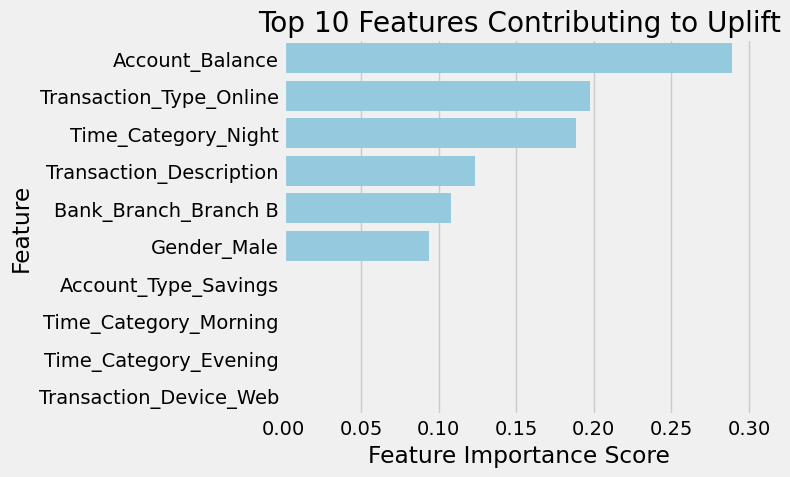

In [25]:
# Top 10 features
top_features = feature_importance_df.head(10)  

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_features, 
    x='Importance', 
    y='Feature', 
    color='skyblue'
)

plt.title("Top 10 Features Contributing to Uplift")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

C:\Users\Palvi\AppData\Local\Temp\ipykernel_26760\1744110842.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=results_df['Age_Group'], y=results_df['CATE'], ci=95, palette=['orange', 'blue'])


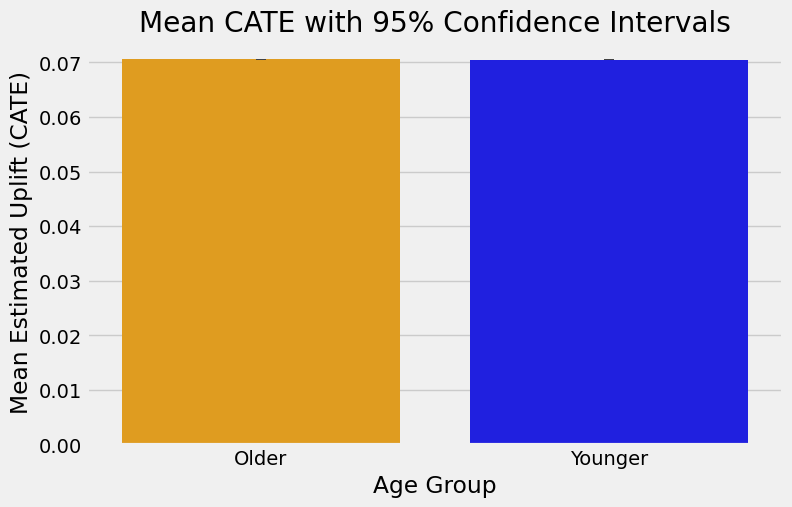

In [26]:
#Plot mean CATE
plt.figure(figsize=(8,5))
sns.barplot(x=results_df['Age_Group'], y=results_df['CATE'], ci=95, palette=['orange', 'blue'])
plt.xlabel("Age Group")
plt.ylabel("Mean Estimated Uplift (CATE)")
plt.title("Mean CATE with 95% Confidence Intervals")
plt.show()


**Interpretation of Mean CATE (95% CI)**

- The mean uplift for both Older and Younger clusters around 0.07, and their 95% confidence intervals overlap substantially.
- This overlap indicates no significant difference in estimated fraud uplift between the two age groups based on this model.
- In practical terms, age (as binned here) does not appear to be a strong driver of fraud risk in these data.

In [3]:
import shap

In [12]:
# SHAP ANALYSIS
# CAUTION: Interpreting SHAP for UpliftTreeClassifier is not straightforward,
# as it's not a standard scikit-learn pipeline. Some advanced hacks are needed

# Initialize SHAP Explainer
explainer = shap.Explainer(uplift_model.predict, X_train.values)

# Compute SHAP values
shap_values = explainer(X_test.values)

PermutationExplainer explainer: 32001it [1:07:12,  7.93it/s]                                                           


Fixed SHAP Values Shape: (32000, 23)
X_test Shape: (32000, 23)


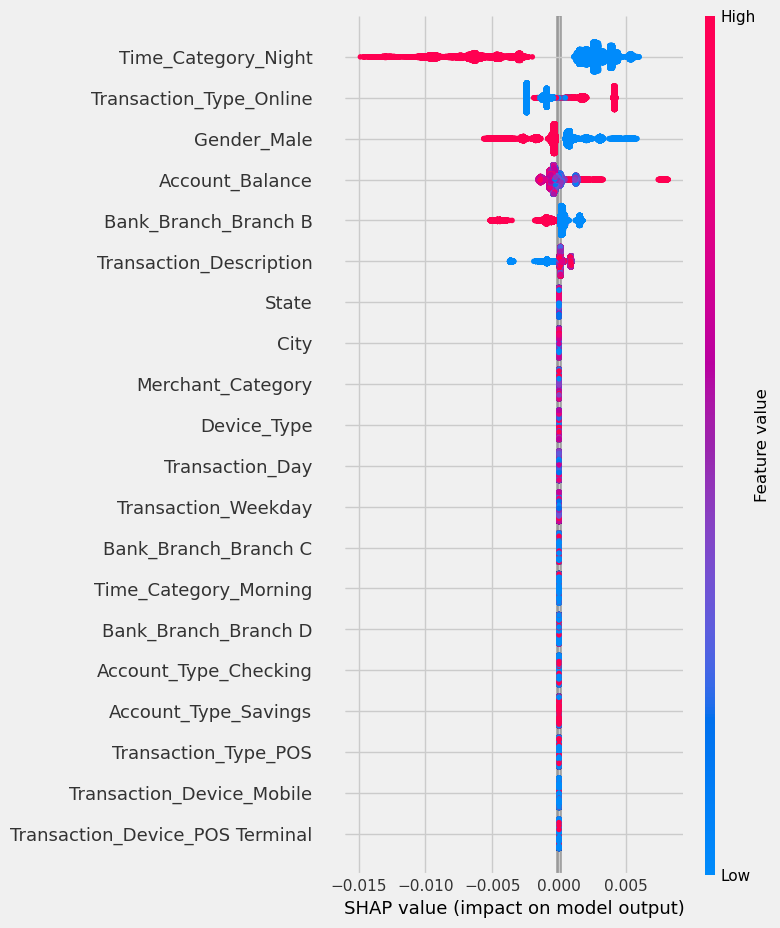

In [13]:
# Extract the correct SHAP values (selecting the treatment effect column)
shap_values_fixed = shap_values[..., 1]  # Selecting the second dimension

# Check if the shapes now match
print(f"Fixed SHAP Values Shape: {shap_values_fixed.shape}")
print(f"X_test Shape: {X_test.shape}")

# Now plot using corrected SHAP values
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values_fixed, X_test, feature_names=X_test.columns)


**SHAP Summary Plot Interpretation**

- Time_Category_Night and Transaction_Type_Online have the widest spread of SHAP values, indicating they strongly influence the model’s predictions. Rows (transactions) with higher “Night” or “Online” signals tend to push the model output (fraud likelihood) higher or lower, depending on the specific instance.
- Gender_Male and Account_Balance also show moderate impact. For Account_Balance, higher balances (pink points) can increase or decrease predicted fraud in different cases, implying a nuanced relationship.
- Many features (e.g., Transaction_Device_Mobile or Transaction_Device_POS Terminal) have near-zero SHAP ranges, suggesting they do not substantially affect the model’s output.
- Overall, time of transaction, transaction type (online vs. offline), gender, and account balance stand out as the most influential predictors of the model’s fraud outcome. The color gradient (blue→pink) shows whether the feature value is low or high for each point, helping explain how each feature instance pushes predictions up or down.

# Causal Inference 2: Transaction Mode Based

After discussion with our professor during our presentation, We took his advice and decided to formulate a second hypothesis centered on Transaction Mode — namely, whether online transactions exhibit a significantly different (higher or lower) fraud risk compared to offline transactions.

The uplift model treats Offline as the “control” group and Online as the “treatment” group. By estimating the Conditional Average Treatment Effect (CATE), we measure how much the probability of fraud changes when a transaction is online instead of offline.

- **Null Hypothesis (H₀):** There is **no significant difference** in fraud likelihood when a transaction is **Online** versus **Offline**.
- 
**Alternative Hypothesis (H₁):** There **is** a significant difference (increase or decrease) in fraud likelihood for **Online** transactions compared to **Offline** transactions.


In [4]:
# 1. Start fresh or use the same df
# Note: We'll reload df in case we changed it above:
df2 = pd.read_csv('data/processed_train_set.csv')
df2.drop(columns=['Transaction_Amount', 'Transaction_Location'], inplace=True, errors='ignore')

In [5]:
# Create a TREATMENT column based on whether transaction is online or not
df2['Transaction_Mode'] = df2['Transaction_Type_Online'].map({True: 'Online', False: 'Offline'})

CONTROL_NAME = 'Offline'
TREATMENT_NAME = 'Online'

In [6]:
# 2. Define Features & Outcome
# Exclude 'Is_Fraud' and 'Transaction_Mode', plus 'Age_Group' if present
features2 = [col for col in df2.columns if col not in ['Is_Fraud', 'Transaction_Mode', 'Age_Group']]
X2 = df2[features2]
y2 = df2['Is_Fraud']

# Convert boolean features to integers
X2 = X2.applymap(lambda x: int(x) if isinstance(x, bool) else x)

C:\Users\Palvi\AppData\Local\Temp\ipykernel_26760\778714240.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X2 = X2.applymap(lambda x: int(x) if isinstance(x, bool) else x)


In [7]:
# 3. Split Data
X2_train, X2_test, y2_train, y2_test, t2_train, t2_test = train_test_split(
    X2, y2, df2['Transaction_Mode'], test_size=0.2, random_state=42
)

In [8]:
# 4. Train UpliftTreeClassifier (Mode-based)
uplift_model2 = UpliftTreeClassifier(
    control_name=CONTROL_NAME,  # 'Offline'
    max_depth=4,
    min_samples_leaf=100
)
uplift_model2.fit(X2_train.values, t2_train.values, y2_train.values)

In [9]:
# 5. Predict CATE
cate_scores_2d_mode = uplift_model2.predict(X2_test.values)
# Typically: [CATE_Offline, CATE_Online]
cate_scores_mode = cate_scores_2d_mode[:, 1]  # index=1 for 'Online'

# 6. Results DataFrame
results_df2 = X2_test.copy()
results_df2['Transaction_Mode'] = t2_test.values
results_df2['Is_Fraud'] = y2_test.values
results_df2['CATE'] = cate_scores_mode

print("\n=== MODE-BASED UPLIFT RESULTS (Offline vs. Online) ===")
print("CATE Summary Statistics by Transaction_Mode:")
print(results_df2.groupby('Transaction_Mode')['CATE'].describe())


=== MODE-BASED UPLIFT RESULTS (Offline vs. Online) ===
CATE Summary Statistics by Transaction_Mode:
                    count      mean       std       min       25%       50%  \
Transaction_Mode                                                              
Offline           19155.0  0.070144  0.005546  0.039106  0.068629  0.068629   
Online            12845.0  0.070204  0.005578  0.039106  0.068629  0.068629   

                       75%       max  
Transaction_Mode                      
Offline           0.077959  0.077959  
Online            0.077959  0.077959  


**Interpretation of CATE Summary (Offline vs. Online)**

- The mean CATE values for Offline and Online transactions are both around 0.07, with very similar standard deviations (0.0055 vs. 0.0056).
- The quartiles (25%, 50%, 75%) are virtually identical, indicating both groups have overlapping distributions of uplift.
- This strongly suggests no major difference in the estimated fraud risk uplift between offline and online transactions according to the model.
- In practical terms, being online (versus offline) does not appear to have a meaningful causal effect on fraud likelihood for this dataset, consistent with the high p-value in the t-test.

C:\Users\Palvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Palvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


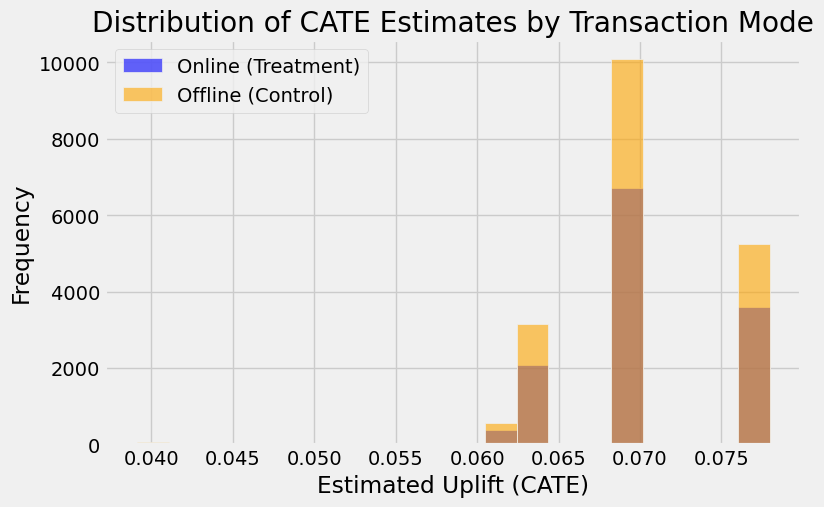

In [10]:
# 7. Visualize Distributions
plt.figure(figsize=(8,5))
sns.histplot(
    data=results_df2.loc[results_df2['Transaction_Mode'] == TREATMENT_NAME],
    x='CATE', bins=20, color='blue', label="Online (Treatment)", alpha=0.6
)
sns.histplot(
    data=results_df2.loc[results_df2['Transaction_Mode'] == CONTROL_NAME],
    x='CATE', bins=20, color='orange', label="Offline (Control)", alpha=0.6
)
plt.xlabel("Estimated Uplift (CATE)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of CATE Estimates by Transaction Mode")
plt.show()


**Interpretation of the Uplift Distributions (Offline vs. Online)**

- Both Offline (control) and Online (treatment) distributions cluster heavily around 0.065–0.070 in estimated uplift, indicating minimal difference in fraud likelihood changes.
- While Offline has slightly more observations near 0.070, and Online is a bit more prominent around 0.065, these differences are not large and substantially overlap.
- This visual aligns with the CATE summary statistics and t-test results, all suggesting that transaction mode (online vs. offline) does not substantially alter fraud risk in this dataset.

In [11]:
# 8. Statistical Test
online_cate = results_df2.loc[results_df2['Transaction_Mode'] == TREATMENT_NAME, 'CATE']
offline_cate = results_df2.loc[results_df2['Transaction_Mode'] == CONTROL_NAME, 'CATE']

t_stat_mode, p_value_mode = ttest_ind(online_cate, offline_cate, equal_var=False)
print(f"T-statistic: {t_stat_mode:.4f}")
print(f"P-value: {p_value_mode:.4f}")

if p_value_mode < 0.05:
    print("Reject null hypothesis: Online transactions significantly impact fraud likelihood.")
else:
    print("Fail to reject null hypothesis: No strong evidence that online vs. offline impacts fraud.")


T-statistic: 0.9456
P-value: 0.3444
Fail to reject null hypothesis: No strong evidence that online vs. offline impacts fraud.


**8T-Test Interpretation**

- We observe a t-statistic of 0.9456 and a p-value of 0.3444, which is well above the standard significance level (0.05).
- Therefore, we fail to reject the null hypothesis, meaning there is no statistically significant evidence that online transactions have a materially different effect on fraud likelihood compared to offline ones.
- This outcome is consistent with the similar mean CATE values and substantial overlap in their distributions, reinforcing the conclusion that transaction mode does not strongly impact fraud risk in this dataset.

C:\Users\Palvi\AppData\Local\Temp\ipykernel_26760\1740241097.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


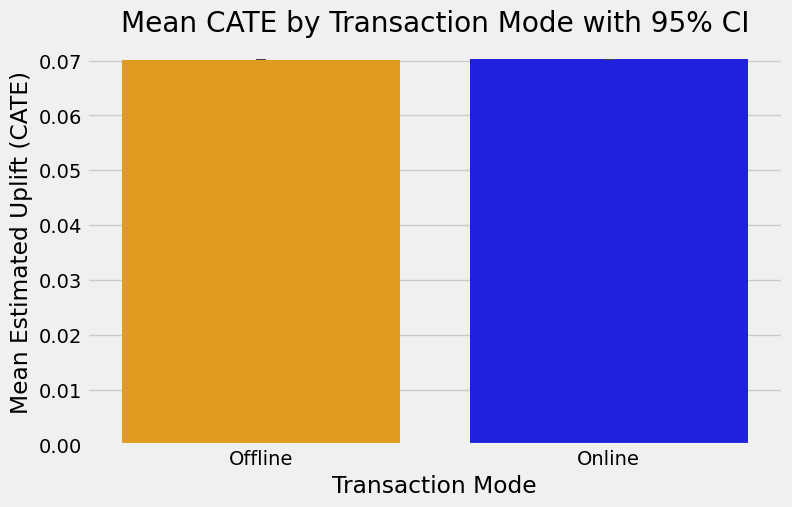

In [13]:
# Quick barplot of average CATE by group
plt.figure(figsize=(8,5))
sns.barplot(
    data=results_df2,
    x='Transaction_Mode',
    y='CATE',
    ci=95,
    palette=['orange', 'blue']
)
plt.xlabel("Transaction Mode")
plt.ylabel("Mean Estimated Uplift (CATE)")
plt.title("Mean CATE by Transaction Mode with 95% CI")
plt.show()


**Interpretation of Mean CATE (95% CI) for Transaction Mode**

- Both Offline and Online bars hover around 0.07, and their 95% confidence intervals overlap, indicating no statistically significant difference.
- This visualization echoes the t-test finding (p-value ≈ 0.34) that transaction mode does not have a strong causal influence on fraud outcome in this dataset.
- Practically, whether a transaction is Online or Offline does not appear to shift fraud risk in a meaningful way here.

PermutationExplainer explainer: 32001it [1:07:53,  7.85it/s]                                                           


SHAP Values Shape: (32000, 23)
X_test Shape: (32000, 23)


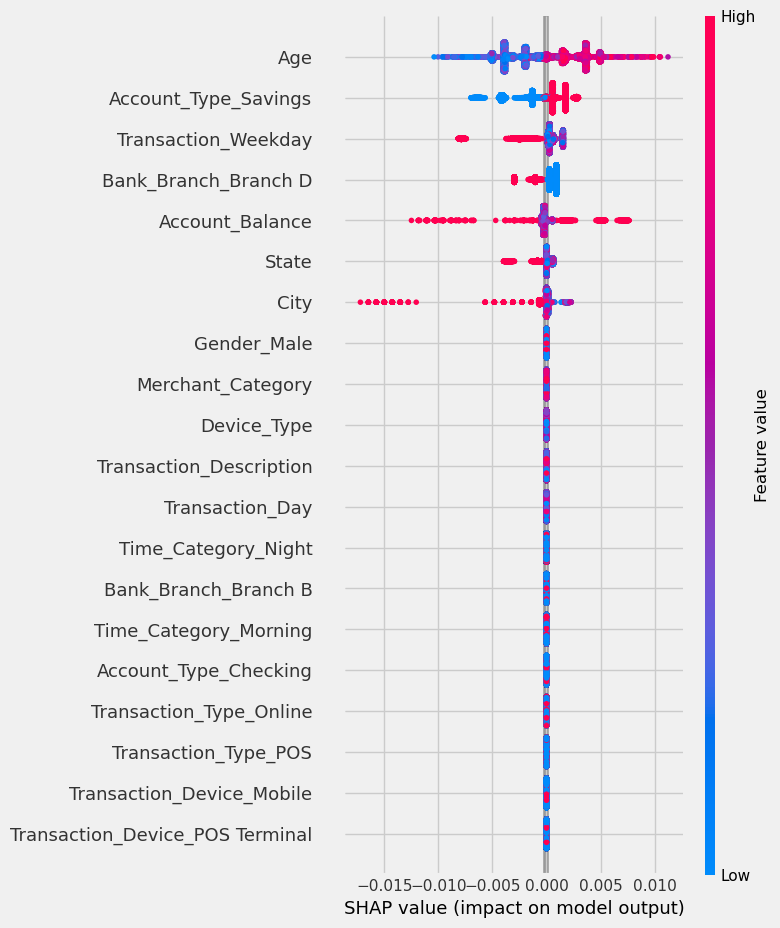

In [14]:
# SHAP Analysis

explainer = shap.Explainer(uplift_model2.predict, X2_train.values)
shap_values_raw = explainer(X2_test.values)
shap_values_online = shap_values_raw[..., 1]  # column=1 for 'Online'
print(f"SHAP Values Shape: {shap_values_online.shape}")
print(f"X_test Shape: {X2_test.shape}")
shap.summary_plot(shap_values_online, X2_test, feature_names=X2_test.columns)

**SHAP Summary Plot Interpretation (Offline vs. Online Model)**

- Age shows the broadest SHAP range, indicating it’s among the most influential features in predicting fraud for this model—even though the primary hypothesis for this experiment was about transaction mode.
- Account_Type_Savings, Transaction_Weekday, and Bank_Branch_Branch D also display moderate impact on the model output, suggesting these factors can shift fraud predictions more than transaction mode.
- Transaction_Type_Online is located toward the lower end of the SHAP value range, implying online vs. offline does not drastically change the model’s fraud predictions compared to other variables.
- This aligns with the t-test result (p-value > 0.05) and CATE distributions, indicating no significant difference in fraud likelihood between online and offline transactions. The SHAP explanation simply confirms that transaction mode is not a dominant predictor of fraudulent outcomes in this dataset.

In [12]:
# Feature Importances
feature_importance2 = uplift_model2.feature_importances_
feature_importance_df2 = pd.DataFrame({
    'Feature': features2,
    'Importance': feature_importance2
}).sort_values(by='Importance', ascending=False)

print("\nTop Features Contributing to Uplift (Transaction Mode):")
print(feature_importance_df2.head(10))


Top Features Contributing to Uplift (Transaction Mode):
                   Feature  Importance
14    Account_Type_Savings    0.186549
0                      Age    0.182893
1                    State    0.163133
8      Transaction_Weekday    0.144743
2                     City    0.117427
12    Bank_Branch_Branch D    0.104120
4          Account_Balance    0.101135
21   Time_Category_Morning    0.000000
20   Time_Category_Evening    0.000000
19  Transaction_Device_Web    0.000000


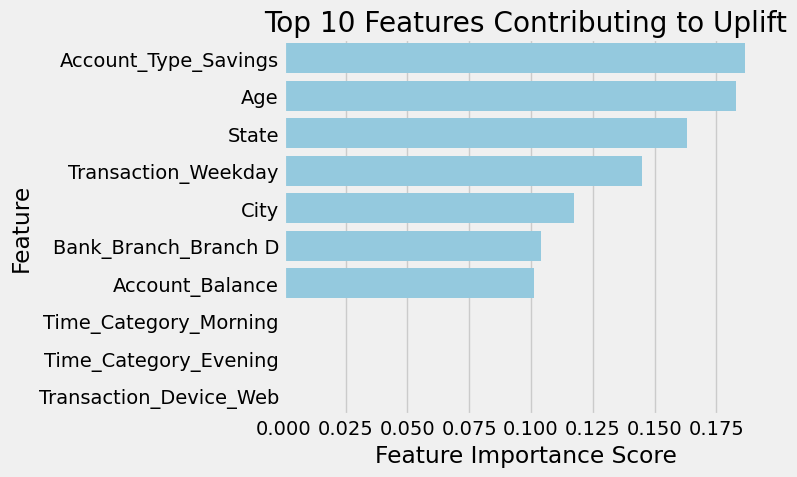

In [16]:
# Top 10 features
top_features2 = feature_importance_df2.head(10)  

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_features2, 
    x='Importance', 
    y='Feature', 
    color='skyblue'
)

plt.title("Top 10 Features Contributing to Uplift")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Overall Takeaways

**Age Group (Younger vs. Older)**
- After splitting the data into “Younger” and “Older,” we found no clear evidence that older individuals face higher or lower fraud risk.
- The model’s estimates show only a slight, practically insignificant difference in fraud likelihood between these two age brackets.
- A statistical test supported this, indicating no meaningful impact of being “Older” versus “Younger.”

**Transaction Mode (Offline vs. Online)**
- We compared offline and online transactions to see if conducting transactions online significantly changes fraud risk.
- The results again showed very similar estimates for both groups, suggesting no major difference in fraud likelihood.
- The t-test confirmed a high p-value, implying there is no strong statistical reason to believe online transactions are riskier or safer than offline ones in this data.

**Feature Importance**
- While age or online/offline status weren’t major drivers, features like account type, account balance, and transaction timing (time of day, weekday) emerged as more influential in the model’s prediction process.
- This implies everyday banking details (e.g., checking vs. savings) and transaction context (e.g., which weekday, which branch) matter more for fraud detection than whether someone is older or the transaction is online.

**Visual Explanations**
- Histograms of the model’s estimated “uplift” (or incremental risk) revealed overlapping distributions, meaning there wasn’t much separation in fraud risk between the compared groups (Older vs. Younger or Offline vs. Online).
- Confidence intervals around the average risk were also nearly identical, reinforcing that neither age nor transaction mode is a decisive factor for fraud likelihood in this dataset.

**Practical Meaning**
- In simpler terms, neither a customer’s age nor a transaction’s offline/online nature seems to systematically raise or lower fraud potential.
- If fraud prevention policies were previously focusing on “Older” customers or “Online” transactions as higher-risk categories, this analysis suggests shifting focus to other indicators (e.g., account behaviors, time of day, or geographic factors) may be more effective.

## Concluding Remarks
Across both hypotheses (age-based and mode-based), the model and statistical tests consistently indicate that age and online/offline transaction status are not key drivers of fraud. Instead, account characteristics, timing, and location appear more relevant. However, we suspect that the underlying dataset may contain synthetic or partially generated records. If so, certain patterns or correlations might not reflect real-world behaviors as accurately. Moving forward, organizations should:

- Validate the authenticity of the data (or gather true, representative samples).
- Prioritize monitoring features like account balance, transaction timing, and branches/cities over making rules based strictly on age or online/offline status.